# Imports

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Density of States

In [30]:
# Thermodynamic DOS (for t = 1)
def dosThermo(eps: np.ndarray) -> np.ndarray:
    eps = np.where(abs(eps) >= 2, np.zeros_like(eps), eps)
    return np.where(abs(eps) >= 2, np.zeros_like(eps), 1 / (2 * np.pi * np.sqrt(1 - (eps**2) / 4)))


# Array with the energy values
points = 800
ee = np.linspace(-1, 1, points)

# If all energy scales are the same, we can pre-compute the exact DOS
dosThermoArr = dosThermo(ee * 2 * 1.01)

# Data Files

In [31]:
import glob


def cheb(n: int, x: float | np.ndarray) -> float | np.ndarray:
    return np.cos(n * np.arccos(x))


# Find all text files starting with "out"
fileListData = glob.glob("out*.txt")

# Organize the data into arrays
dataArr = []
for file in fileListData:
    _, L, t, w, NAverages, Nmoments = file.split("-")
    L, t, w, NAverages, Nmoments = int(L), float(t), float(w), int(NAverages), int(Nmoments[:-4])
    
    # Load the file as an array of floats
    dataNum = np.genfromtxt(file, dtype=float)
    dataNum = dataNum.T

    # Use t = 1
    wt = w / t

    # Clip for Chebyshev polynomials
    eecc = ee[1:-1]

    # Get Chebyshev coeffcients
    mm = dataNum
    
    # Compute the DOS
    rho = np.zeros(len(eecc))
    rho = mm[0] * (1/np.pi) * 1 / np.sqrt(1 - eecc**2)
    for n in range(1, Nmoments):
        rho += mm[n] * (2/np.pi) * 1 / np.sqrt(1 - eecc**2) * cheb(n, eecc)
    
    # Rescale data
    energy_scale = (2 + wt/2) * 1.01
    eedata = ee * energy_scale
    rho /= energy_scale

    # Store
    dataNum = [0] + list(rho) + [0]
    dataArr += [(L, wt, NAverages, Nmoments, eedata, dataNum, dosThermoArr)]


# Find all text files starting with "time"
fileListTime = glob.glob("time*.txt")

# Get time data
ttArr, rrArr, uuArr = [], [], []
for fileName in fileListTime:
    with open(fileName, "r") as file:
        text = file.read().split("\n")
        text = [item for item in text if len(item) > 2]

    tt, rr, uu = [], [], []
    # Timing with time function
    # for index in range(len(text) // 4):
    #     index *= 4
    #     tt += [int(text[index].split("=")[-1])]
    #     rr += [float(text[index + 1].split("m")[-1][:-1])]
    #     uu += [float(text[index + 2].split("m")[-1][:-1])]

    # Timing itself
    for item in text:
        item = item.split()
        tt += [int(item[5][:-1])]
        rr += [float(item[6])]

    ttArr += [tt]
    rrArr += [rr]
    uuArr += [uu]

ttArr = np.array(ttArr)
rrArr = np.array(rrArr)
uuArr = np.array(uuArr)

# Visualization

In [32]:
def plotAll(dataArr: list, cols: int) -> None:
    # Needed number of columns
    rows = len(dataArr) // cols + 1
    for index, item in enumerate(dataArr):
        # Getting data
        L, wt, NAverages, Nmoments, eedata, dataNum, dosThermoArr = item

        # Plotting
        plt.title(f"Density of States for L = {L} and w/t = {wt} with {NAverages} Averages and {Nmoments} Moments")
        plt.plot(eedata, dataNum, label="Calculated DOS")
        plt.plot(eedata, dosThermoArr, label="Thermodynamic DOS")
        plt.xlabel("$\\varepsilon / t$")
        plt.ylabel("$\\rho(\\varepsilon) \\times t$")
        plt.legend()
        plt.show()

        # Analysis
        print(f"Density of States for L = {L} and w/t = {wt} with {NAverages} Averages and {Nmoments} Moments")
        print(f"Average difference is {np.mean(dataNum - dosThermoArr)}")
        print(f"Average absolute difference is {np.mean(np.abs(dataNum - dosThermoArr))}")
        print(f"Maximum absolute difference is {np.max(np.abs(dataNum - dosThermoArr))}")
        print("\n\n")

    plt.show() 

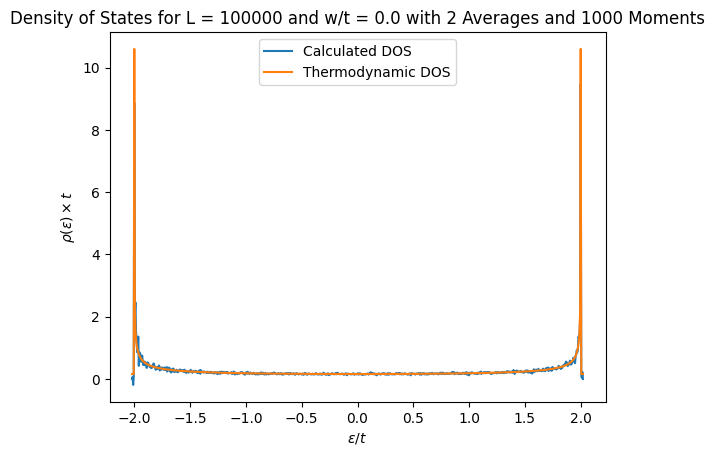

Density of States for L = 100000 and w/t = 0.0 with 2 Averages and 1000 Moments
Average difference is -0.003682873279732638
Average absolute difference is 0.028799671883435504
Maximum absolute difference is 1.7368322156173512





In [33]:
plotAll(dataArr, 2)

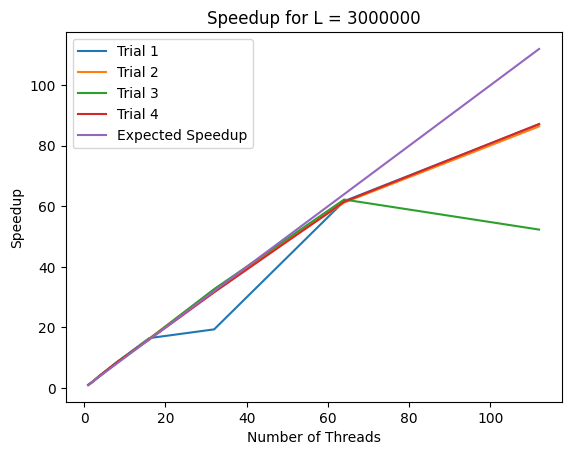

In [34]:
plt.title(f"Speedup for L = 3000000")
for tt, rr, index in zip(ttArr, rrArr, range(0, len(ttArr))):
    plt.plot(tt, rr[0] / rr, label=f"Trial {index+1}")

plt.plot(tt, tt, label="Expected Speedup")
plt.xlabel("Number of Threads")
plt.ylabel("Speedup")
plt.legend()